In [20]:
import os
import warnings
import sys

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor

import mlflow
import mlflow.sklearn

import matplotlib.pyplot as plt

In [46]:
data = pd.read_csv("C:\\Users\\MaryWillcock\\Documents\\GitHub\\RouteForecast\\JacobusExampleData.csv")
data.head()

,Date,DOW,Stop,Gallons
0,1/8/2019,Tuesday,Cust3,2108
1,1/15/2019,Tuesday,Cust3,2335
2,1/22/2019,Tuesday,Cust3,2383
3,1/29/2019,Tuesday,Cust3,2060
4,2/5/2019,Tuesday,Cust3,1836


In [47]:
data = data[['DOW','Stop','Gallons']].copy()

In [48]:
convert_to_num = {'Sunday' : 0, 'Monday' : 1, 'Tuesday':2,'Wednesday' : 3, 'Thursday' : 4, 'Friday':5,'Saturday' : 6}
data['DOW'] = data['DOW'].map(convert_to_num)
convert_to_num2 = {'Cust1' : 0, 'Cust2' : 1, 'Cust3':2}
data['Stop'] = data['Stop'].map(convert_to_num2)
data['Stop'].astype(int)
data['DOW'].astype(int)
data['Gallons'].astype(int)
data.head()

,DOW,Stop,Gallons
0,2,2,2108
1,2,2,2335
2,2,2,2383
3,2,2,2060
4,2,2,1836


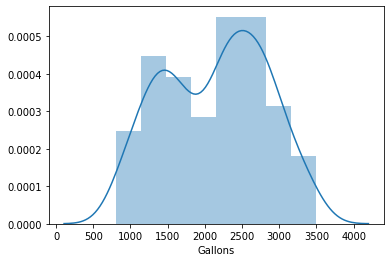

In [49]:
import seaborn as sns
fig, ax = plt.subplots()
#histogram
sns.distplot(data['Gallons'])

In [50]:
# Split the data into training and test sets. (0.75, 0.25) split.
train, test = train_test_split(data)

# The predicted column is "Gallons"
train_x = train.drop(["Gallons"], axis=1)
test_x = test.drop(["Gallons"], axis=1)
train_y = train[["Gallons"]]
test_y = test[["Gallons"]]

In [62]:
def train(in_n_estimators, tag):
    warnings.filterwarnings("ignore")
    np.random.seed(40)
    
    def eval_metrics(actual, pred):
        rmse = np.sqrt(mean_squared_error(actual, pred))
        mae = mean_absolute_error(actual, pred)
        r2 = r2_score(actual, pred)
        return rmse, mae, r2
    
    #Split test and train, then pickle data to later save as artifact 
    
    data.to_pickle('data.pkl')
        
    # Set default values if no alpha is provided
    if float(in_n_estimators) is None:
        n_estimators = 100
    else:
        n_estimators = int(in_n_estimators)   

    with mlflow.start_run(run_name='TEST'):
        rf = RandomForestRegressor(n_estimators=n_estimators)
        rf.fit(train_x, train_y)

        predicted_qualities = rf.predict(test_x)
   
        (rmse, mae, r2) = eval_metrics(test_y, predicted_qualities)

        print("  RMSE: %s" % rmse)
        print("  MAE: %s" % mae)
        print("  R2: %s" % r2)

        mlflow.log_param("n_estimators", n_estimators)
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("r2", r2)
        mlflow.log_metric("mae", mae)

        mlflow.sklearn.log_model(rf, "model")
        mlflow.set_tag('Feature Engineering', tag )
        mlflow.log_artifact('data.pkl')
        
        print("Model saved in run %s" % mlflow.active_run().info.run_uuid)
        return predicted_qualities
        mlflow.end_run(status='FINISHED')
    mlflow.end_run(status='FINISHED')

In [69]:
tag = "Base Data"
predicted_qualities = train(200,  tag)

  RMSE: 267.43885008802124
  MAE: 228.54609666894095
  R2: 0.850427092831842
Model saved in run 958e92a2189e4b85b101822be5cb1f0b


In [86]:
pred = pd.DataFrame(predicted_qualities)
test = pd.DataFrame(test_y)
test1 = test.reset_index(drop=True)
testPred = pd.merge(pred, test1,left_index=True, right_index=True)
testPred.columns = ['predGal', 'Gal']
testPred

,predGal,Gal
0,2693.778273,2813
1,2429.431799,2598
2,1187.949238,1169
3,2429.431799,2536
4,2983.422004,2899
...,...,...
73,2983.422004,3424
74,2009.043608,1500
75,1187.949238,915
76,1454.484903,1483


In [92]:
fullTest = test.merge(data, left_index=True, right_index=True)
fullTest = fullTest.drop('Gallons_y', axis=1)
fullTest.columns = ['Gallons','DOW','Stop']
fullTest.head()

,Gallons,DOW,Stop
100,2813,5,2
246,2598,2,0
204,1169,5,1
223,2536,2,0
309,2899,5,0


In [94]:
fullTest1 = fullTest.reset_index(drop=True)
fullTestPred = pd.merge(pred, fullTest1,left_index=True, right_index=True)
fullTestPred.columns = ['predGal', 'Gallons','DOW','Stop']
fullTestPred.head()

,predGal,Gallons,DOW,Stop
0,2693.778273,2813,5,2
1,2429.431799,2598,2,0
2,1187.949238,1169,5,1
3,2429.431799,2536,2,0
4,2983.422004,2899,5,0


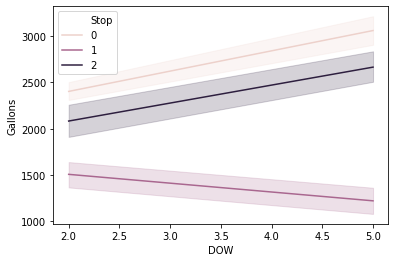

In [98]:
sns.lineplot(x='DOW', y='Gallons',hue='Stop',data=fullTestPred)

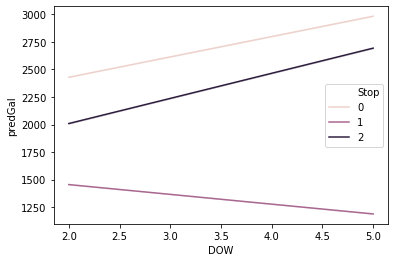

In [99]:
sns.lineplot(x='DOW', y='predGal',hue='Stop',data=fullTestPred)

Text(0.5, 0, 'actual / predicted')

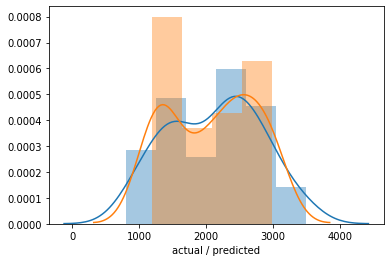

In [104]:
#Visualizing the data - displot
plot_income = sns.distplot(fullTestPred["Gallons"])
plot_spend = sns.distplot(fullTestPred["predGal"])
plt.xlabel('actual / predicted')

Text(0.5, 0, 'actual / predicted')

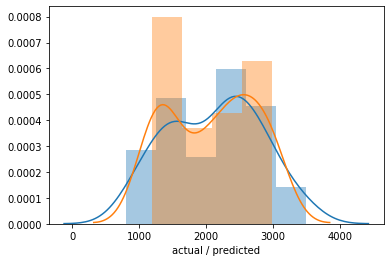

In [105]:
#Visualizing the data - displot
plot_income = sns.distplot(fullTestPred["Gallons"])
plot_spend = sns.distplot(fullTestPred["predGal"])
plt.xlabel('actual / predicted')